# Game Bot
Let's start with imports

In [1]:
from PIL import Image, ImageFilter
from imagehash import average_hash
import pyscreenshot as ImageGrab
from mss import mss
from tqdm import tqdm
from IPython.display import display
import numpy as np
import pytesseract
import concurrent.futures
import os
import sys
import random
import time
import pdb
import keras
from pathlib import Path
import win32api, win32con
from random import sample
from keras import backend as K
import random
import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import sgd, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from functools import partial

C:\Users\Matias\RealAnaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Set up Network
* Image input should be 300px by 300px
* Output layer should be equal to the number of possible actions, which in this case is 2 (click or no click)
* Epsilon-related values concern the ratio between exploring/exploiting. The earlier in the training process we are, the more exploration we will do. In short, we will perform a lot of random actions in the beginning, and gradually allow the model to predict more frequently.

In [2]:
if 'session' in locals() and session is not None:
    session.close()
    
output_size = 2 # either tap or no tap

# Deep-Q learning Agent
class DQNAgent:
    def __init__(self):
        self.memory = []
        self.gamma = 0.9 
        self.epsilon = 1  # exploration
        self.epsilon_decay = .995
        self.epsilon_min = 0.1
        self.learning_rate = 0.0001
        self._build_model()
    
    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=(4,4),input_shape=(1,300,300), padding='same', activation='relu'))
        model.add(Conv2D(64, (4, 4), strides=(2,2), padding='same', activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1,1), padding='same', activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='linear'))
        model.add(Dense(output_size, activation='softmax')) # output layer, todo softmax

        model.compile(loss='mse', optimizer=Adam(lr=1e-6))
        self.model = model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if not check_ready_for_action():
            action = None
        elif np.random.rand() <= self.epsilon:
            action = int(random.uniform(0, output_size))
        else:
            act_values = self.model.predict(state)
            action = int(np.argmax(act_values[0]))
        print(f'Action is : {action}')
        return action

    def replay_batch(self, batch):
        state, action, reward, next_state, done = self.memory[batch]
        target = reward
        if not done:
            target = reward + self.gamma * np.argmax(self.model.predict(next_state))
        target_f = self.model.predict(state)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)
        
    def replay(self, batch_size):
        print('Replay')
        if len(self.memory) == 0:
            return
        
        batches = min(batch_size, len(self.memory))
        batches = np.random.choice(len(self.memory), batches)
        for batch in tqdm(batches):
            self.replay_batch(batch)
            
        self.model.save_weights('model_skiing_penguin.h5')
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        print(f'Epsilon is {self.epsilon}')

## Configurations

In [3]:
pytesseract.pytesseract.tesseract_cmd = str(Path.cwd()/'tesseract/tesseract')
K.set_image_dim_ordering('th')

# orig_stdout = sys.stdout
# f = open('out.txt', 'w')
# sys.stdout = f

x_pad, y_pad = win32api.GetSystemMetrics(0), win32api.GetSystemMetrics(1)
game_play_dim = (x_pad*0.715, y_pad*0.04, x_pad, y_pad*0.94)

### Movements

In [4]:
top_right = (-int(x_pad*0.04), -int(y_pad*0.9))

restart_button = (-int(x_pad*0.23), -int(y_pad*0.5))

def mouse_pos(cord):
    """
    Setting mouse position relative to screen dimensions
    """
    win32api.SetCursorPos((x_pad + cord[0], y_pad + cord[1]))

def left_hold(movement = None):
    """
    Certain movements need to have the left mouse button held down
    In case there is no movement, it is just a regular click
    """
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTDOWN, 0 ,0)
    time.sleep(.1)
    if movement:
        movement()
    win32api.mouse_event(win32con.MOUSEEVENTF_LEFTUP, 0 ,0)

def pause():
    pass
#     mouse_pos(top_right)
#     left_hold()
    
def unpause():
    pass
#     mouse_pos('x')
#     left_hold()

def restart():
    mouse_pos(restart_button)
    time.sleep(0.1)
    left_hold()
    
def reset():
    """ Repeats NO-OP action until a new episode begins. """
    restart()
    time.sleep(1)
    state = take_screenshot()
#     pause()
    return state

## Helpers

In [147]:
def select_action(action):
    """ executes action, last action is "do nothing" """
    try:
        [left_hold, lambda: None][action]()
    except Exception as e:
        print(e, action)
        
def timeit(method):
    """
    Performance Monitoring
    """
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print(f'{method.__name__}  {(te - ts) * 1000} ms')
        return result
    return timed

def get_cords():
    """
    Useful for debugging
    """
    x,y = win32api.GetCursorPos()
#     print (x,y)
    x = x - x_pad
    y = y - y_pad
    print (f'x = {x},y = {y}')

test_ob = ImageDataGenerator(rescale=1./255) 

def preprocess(im):
    """
    Before neural net
    """
#     im = im.resize((300,300)).convert('L')
#     print("[INFO] loading and preprocessing image...")
#     image = img_to_array(im)
#     image.reshape((1,) + image.shape)  # this is a Numpy array with shape (1, 3, 300, 300)
    im = im.resize((300,300))
    im = im.convert('L')
    image = img_to_array(im)
    image = image.reshape((1,) + image.shape)  # this is a Numpy array with shape (1, 3, 300, 300)

    X = []
    for batch in test_ob.flow(image, batch_size=1):
        X = batch
        break
    return X

def take_screenshot():
    with mss() as sct:
        monitor = sct.monitors[1]
        sct_img = sct.grab(monitor)
        return Image.frombytes(
            'RGB', sct_img.size, sct_img.bgra,
            'raw',
            'BGRX',
        ).crop(game_play_dim).rotate(90, expand=1) # whole image will not fit without `expand=1`

def get_crop_values(left, top, width, height):
    return (left, top, left+width, top+height)

INTRO_VIEW = 'SKIING'
def check_landing(box = get_crop_values(270, 70, 120, 30)):
    im = take_screenshot().crop(box)
    text = pytesseract.image_to_string(im, config=f'--oem 0 -psm 6 -c tessedit_char_whitelist={INTRO_VIEW}')
    return any(val in text for val in INTRO_VIEW)

actionable_image_hash = average_hash(Image.open('./actionable_state.png'), 50)
def check_ready_for_action(box = get_crop_values(150, 200, 70, 190), diff_threshold = 25):
    """
    We can only perform an action when the penguin is touching the ice
    Here, we are doing a similarity check between two images
    """
    im = take_screenshot().crop(box).filter(ImageFilter.SMOOTH).convert('L')
    new_hash = average_hash(im, 50)
    diff = new_hash - actionable_image_hash
    print(f'diff is {diff}')
    return diff < diff_threshold
    
# Check if we did not lose game
GAME_OVER = 'Score'    
def check_game_over(box = get_crop_values(0.36*y_pad, 80, 126, 30)):
    im = take_screenshot().crop(box)
    text = pytesseract.image_to_string(im, config=f'--oem 0 -psm 6 -c tessedit_char_whitelist={GAME_OVER}')
    if any(val in text for val in GAME_OVER) and len(text) > 5:
        print('Game over encountered')
        print(f'text was {text}')
        return True
    else:
        return False
    
def get_score(box = get_crop_values(0.422*x_pad, 32, 70, 32)):
    im = take_screenshot().crop(box)
    im = im.resize((170, 80)).filter(ImageFilter.SMOOTH)
    text = pytesseract.image_to_string(im, config=f'--oem 0 -psm 6 -c tessedit_char_whitelist=0123456789')
    try:
        return int(text)
    except Exception as e:
        print(e, text)
        return None

## Gameplay

In [6]:
def step(action, score):
    executor = concurrent.futures.ThreadPoolExecutor()
    futures = [executor.submit(get_score), executor.submit(check_game_over)]
    res0, res1 = [future.result() for future in concurrent.futures.as_completed(futures, timeout=50.0)]
    
    if type(res0) == bool:
        done = res0
        s = res1
    else:
        s = res0
        done = res1

    if done or s is None:
        reward = 0
        s = score
    else:
        if s is None:
            s = score
        elif s > score:
            reward = 1000
        else:
            reward =- 250
#         pause()
        
        if action is not None:
            select_action(action)
            time.sleep(0.2)

        s = get_score()
        if s == -1:
            s = score
        if done or s is None:
            reward = 0
            s = score
        else:
            if s > score:
                reward = 1000
            else:
                reward = -250
    state = take_screenshot()
#     time.sleep(0.2)
#     pause()
    return state, reward, done, s, {}    

In [148]:
if __name__ == '__main__':
#     check if app booted
    if check_landing():
        mouse_pos((-210, -400))
        time.sleep(0.1)
        left_hold()
    elif check_game_over():
        restart()
        
    agent = DQNAgent()
    try:
        agent.model.load_weights('model_skiing_penguin.h5')
    except:
        pass
    episodes = 1200

    for e in range(episodes):
        state = reset()
        state = preprocess(state)
        score = 0
        for time_t in range(5000):

            action = agent.act(state)
            next_state, reward, done, score, info = step(action, score)

            if action is None and not done:
                continue
            else:
                next_state = preprocess(next_state)
                reward = -5000 if done else reward
                agent.remember(state, action, reward, next_state, done)
                state = copy.deepcopy(next_state)

            if done:
                print(f'episode: {e}/{episodes}, score: {score}')
                break
            
        agent.replay(32)

diff is 370
Action is : None
diff is 1305
Action is : None
diff is 1108
Action is : None
diff is 14
Action is : 0
diff is 635
Action is : None
diff is 1129
Action is : None
diff is 930
Action is : None
diff is 16
Action is : 0
diff is 680
Action is : None
diff is 1249
Action is : None
invalid literal for int() with base 10: '' 
diff is 835
Action is : None
invalid literal for int() with base 10: '' 
diff is 226
Action is : None
invalid literal for int() with base 10: '' 
diff is 12
Action is : 0
invalid literal for int() with base 10: '' 
diff is 9
Action is : 1
invalid literal for int() with base 10: '' 
diff is 11
Action is : 0
invalid literal for int() with base 10: '' 
diff is 9
Action is : 1
invalid literal for int() with base 10: '' 
diff is 9
Action is : 1
invalid literal for int() with base 10: '' 
diff is 9
Action is : 0
invalid literal for int() with base 10: '' 
diff is 11
Action is : 0
invalid literal for int() with base 10: '' 
diff is 11
Action is : 1
invalid literal for 

KeyboardInterrupt: 

In [ ]:
#TODO: ONLY PERFORM ACTION WHENEVER POSSIBLE, IS WHEN PENGUIN IS TOUCHING ICE

In [ ]:
# TODO: CALCULATE TIME BETWEEN JUMP AND AFTER JUMP!

In [146]:
box = get_crop_values(150, 200, 70, 190)
diff_threshold = 120
"""
We can only perform an action when the penguin is touching the ice
Here, we are doing a similarity check between two images
"""
im = take_screenshot().crop(box).filter(ImageFilter.SMOOTH).convert('L')
new_hash = average_hash(im, 50)
diff = new_hash - actionable_image_hash
print(f'diff is {diff}')

diff is 270


In [131]:
im.save('./actionable_state.png')

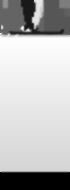

In [132]:
im